In [7]:
import numpy as np
import copy
import matplotlib.pyplot as plt


def actime(E):
    """
    Calculate the autocorrelation time for a time series E

    Args:
        E (np.array): array of energies, shape (N,)
    Returns:
        (float, int): (kappa, tcutoff), the autocorrelation time and the cutoff time
    """

    mu = np.mean(E)
    std = np.std(E, ddof=1)
    N = E.shape[0]
    ts = np.arange(0, N, 1)

    a_diffs = np.zeros((N, N))

    for t in ts:
        a_diffs[t][: N - t] = (E[: N - t] - mu) * (E[t:] - mu)

    autocorrelation = np.sum(a_diffs, axis=1) / std**2 / (N - ts)
    tcutoff = (
        np.where(autocorrelation <= 0)[0][0] if (autocorrelation <= 0).any() else 0
    )
    kappa = 1 + 2 * np.sum(autocorrelation[1:tcutoff])

    return autocorrelation, kappa, tcutoff


def totalMagnetization(lattice):
    """Total magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, nx)
        2D lattice of +1 and -1

    Returns
    -------
    int
        total magnetization
    """
    mtot = 0
    if lattice.ndim == 2:
        mtot = np.sum(lattice.flatten())

    elif lattice.ndim == 3:
        mtot = np.sum(lattice, axis=(1, 2))

    return mtot


def varMagnetization(lattice):
    """Variance of magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1

    Returns
    -------
    float
        variance of magnetization
    """
    varMag = np.var(lattice.flatten(), ddof=1)
    return varMag


def neighborList(i, j, N):
    """Find all neighbors of site (i, j).

    Parameters
    ----------
    i : int
        site index along x
    j : int
        site index along y
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of 2-tuples, [(i_left, j_left), (i_above, j_above),
        (i_right, j_right), (i_below, j_below)]
    """

    left = (i - 1, j)
    above = (i, j + 1)
    right = (i + 1, j)
    below = (i, j - 1)

    # fix these indices
    if i == N - 1:
        right = (0, j)

    elif i == 0:
        left = (N - 1, j)

    if j == N - 1:
        above = (i, 0)

    elif j == 0:
        below = (i, N - 1)

    return np.array([left, above, right, below])


def energySite(i, j, lattice):
    """Calculate energy associated with site (i, j)

    The sum of energy_site over all sites should be 2* total energy.

    Parameters
    ----------
    i : int
        site index along x
    j : int
        site index along y
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1

    Returns
    -------
    float
        energy of site (i, j)
    """

    N = lattice.shape[0]
    neighbors = neighborList(i, j, N)
    x_indices = neighbors[:, 0]
    y_indices = neighbors[:, 1]
    energy = lattice[i, j] * np.sum(lattice[x_indices, y_indices].flatten())
    return energy


def spinFlipRandom(lattice, i, j, beta):
    """Calculate spin flip probability and change to total magnetization.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    beta : float
        inverse temperature

    Returns
    -------
    float
        acceptance ratio
    int
        change to total magnetization due to the spin flip
    """

    dE = -2 * energySite(i, j, lattice)
    A = np.exp(-beta * dE)
    dM = -2 * lattice[i, j]
    return A, dM


def sampleSpinHeatbath(lat, i, j, betaj, rcheck):
    """sample spin for site (i, j) using heat-bath algorithm

    Parameters
    ----------
    lat : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    betaj : float
        inverse temperature in reduced units
    rcheck : float
        uniform random number for proposed move

    Returns
    -------
    int
        sampled spin
    int
        change to total magnetization
    """

    lattice = copy.deepcopy(lat)
    s0 = lattice[i, j]
    lattice[i, j] = 1
    Pup = np.exp(-betaj * energySite(i, j, lattice))
    lattice[i, j] = -1
    Pdown = np.exp(-betaj * energySite(i, j, lattice))
    T = Pup / (Pup + Pdown)
    if rcheck < T:
        s = 1
    else:
        s = -1
    dmtot = -(s0 - s)
    return s, dmtot


def initLattice(N):
    """Initialize lattice.

    Parameters
    ----------
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        2D lattice of +1
    """
    # lattice = np.random.choice([-1, 1], size=(N, N))
    lattice = np.ones((N, N))
    return lattice


def simulateMetropolis(lattice, beta, nsweeps):
    """Simulate Ising model using Metropolis algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Lattices = np.zeros((nsweeps, N, N))
    for sweep in range(nsweeps):
        for i in range(N):
            for j in range(N):
                A, dM = spinFlipRandom(lattice, i, j, beta)
                rcheck = np.random.rand()
                if rcheck < A:
                    lattice[i, j] *= -1

        Lattices[sweep] = lattice

    return Lattices


def simulateHeatbath(lattice, beta, nsweeps):
    """Simulate Ising model using heat-bath algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Lattices = np.zeros((nsweeps, N, N))
    for sweep in range(nsweeps):
        for i in range(N):
            for j in range(N):
                rcheck = np.random.rand()
                s, dmtot = sampleSpinHeatbath(lattice, i, j, beta, rcheck)
                lattice[i, j] = s

        Lattices[sweep] = lattice

    return Lattices


def cluster(beta, lattice, N):
    """
    Cluster algorithm for Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of sites in cluster
    """

    lattice = copy.deepcopy(lattice)
    pos = np.random.randint(0, N, 2)
    s = lattice[pos[0], pos[1]]
    allpos = np.where(lattice == s)
    allpos = np.vstack([allpos[0], allpos[1]]).T
    cluster = []
    passed = []
    cluster.append(pos)
    neighbors = []
    neighbors.extend(neighborList(pos[0], pos[1], N))

    while len(neighbors) > 0:
        i = neighbors[0]

        if (np.isin(i, allpos).all()) and (np.isin(i, passed).all()):
            if (1 - np.exp(-2 * beta)) > np.random.random():
                cluster.append(i)
                neighbors.extend(neighborList(i[0], i[1], N))

            passed.append(i)
        del neighbors[0]
    cluster = np.vstack(cluster)
    return cluster


def simulateCluster(lattice, beta, nsweeps):
    """Simulate Ising model using cluster algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """

    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Latices = np.zeros((nsweeps, N, N))

    for sweep in range(nsweeps):
        c = cluster(beta, lattice, N)
        lattice[c] *= -1

        Latices[sweep] = lattice

    return Latices

### Metropolis

### 1.

$T(old \rightarrow new) = min(1, \exp{-\Delta V})$

$T(new \rightarrow old) = min(1, \exp{\Delta V})$

$dE = -2 * Eij$

$A = \exp{-\beta \cdot dE}$

### 2.

In [8]:
def totalEnergy(lattices):
    energies = np.zeros(lattices.shape[0])

    for i in range(lattices.shape[0]):
        lattice = lattices[i]
        N = lattice.shape[0]
        energy = 0
        for i in range(N):
            for j in range(N):
                energy += energySite(i, j, lattice)
        energies[i] = energy / 2

    return energies

In [13]:
betas = np.linspace(1e-4, 0.1, 5)
# betas[3] = 0.44069
nsims = betas.shape[0]
spinsPerSide = 20
nparticles = spinsPerSide**2
lattice = initLattice(spinsPerSide)
nsweeps = 1000
Ms = np.zeros((nsims, nsweeps))
autocorrelations = np.zeros((nsims, nsweeps))
kappas = np.zeros(nsims)
tcutoffs = np.zeros(nsims)
Merrors = np.zeros(nsims)
energies = np.zeros((nsims, nsweeps))
for idx, beta in enumerate(betas):
    if beta == 0.44069:
        Ms_special = np.zeros((10, nsweeps))

        for i in range(10):
            Lattices = simulateMetropolis(lattice, beta, nsweeps)
            M = (totalMagnetization(Lattices) / nparticles) ** 2
            Ms_special[i] = M

        M = np.mean(Ms_special, axis=0)
        autocorrelation, kappa, tcutoff = actime(M)
        Ms[idx] = M
        autocorrelations[idx] = autocorrelation
        kappas[idx] = kappa
        tcutoffs[idx] = tcutoff
        Merrors[idx] = np.std(Ms_special.flatten(), ddof=1) / np.sqrt(10)

        continue

    Lattices = simulateMetropolis(lattice, beta, nsweeps)
    M = (totalMagnetization(Lattices) / nparticles) ** 2
    autocorrelation, kappa, tcutoff = actime(M)
    Ms[idx] = M
    autocorrelations[idx] = autocorrelation
    kappas[idx] = kappa
    tcutoffs[idx] = tcutoff
    Merrors[idx] = np.std(M, ddof=1) / spinsPerSide
    energies[idx] = totalEnergy(Lattices)

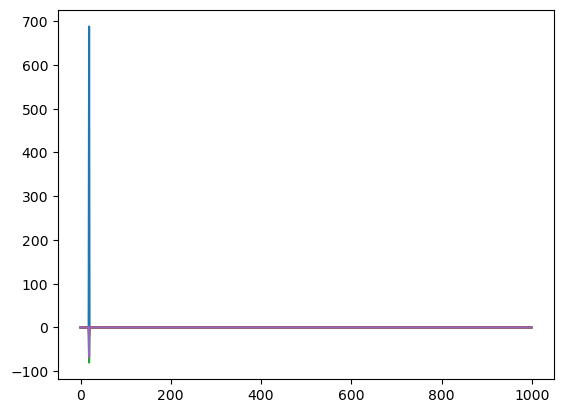

In [14]:
for E in energies:
    plt.plot(E)

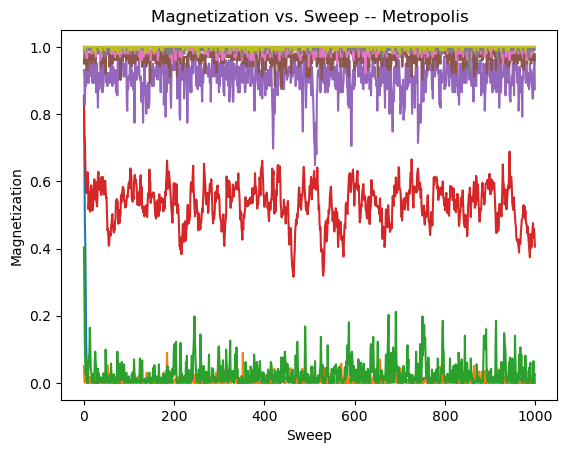

In [60]:
for M in Ms:
    plt.plot(M)

plt.xlabel("Sweep")
plt.ylabel("Magnetization")
plt.title("Magnetization vs. Sweep -- Metropolis")
plt.show()

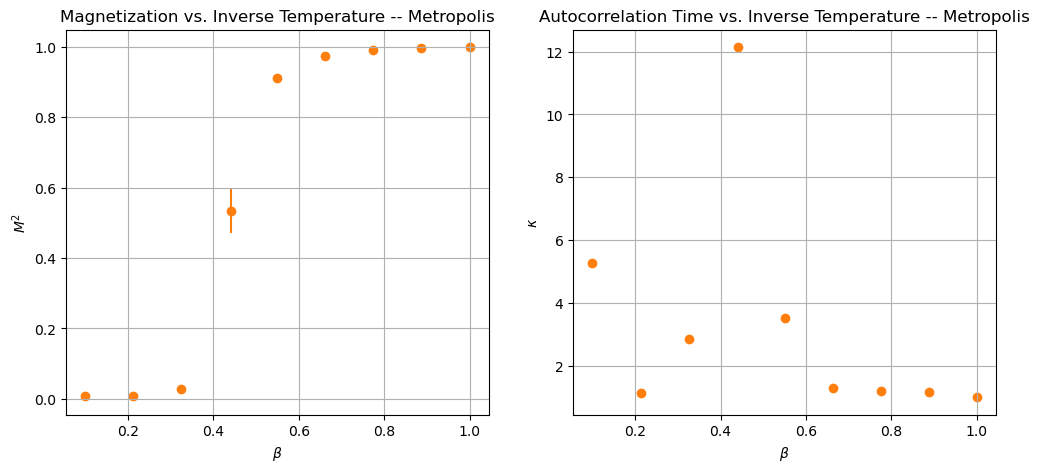

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for idx, M in enumerate(Ms):
    axs[0].scatter(betas[idx], np.mean(M), color="C1")
    axs[0].errorbar(betas[idx], np.mean(M), yerr=Merrors[idx], color="C1")
    axs[1].scatter(betas[idx], kappas[idx], color="C1")
    err = Merrors[idx]

axs[0].set_xlabel(r"$\beta$")
axs[0].set_ylabel(r"$M^{2}$")
axs[0].set_title("Magnetization vs. Inverse Temperature -- Metropolis")
axs[0].grid()

axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel(r"$\kappa$")
axs[1].set_title("Autocorrelation Time vs. Inverse Temperature -- Metropolis")
axs[1].grid()
plt.show()

In [62]:
betas = np.linspace(0.1, 1, 9)
betas[3] = 0.44069
nsims = betas.shape[0]
spinsPerSide = 20
nparticles = spinsPerSide**2
lattice = initLattice(spinsPerSide)
nsweeps = 1000
Ms = np.zeros((nsims, nsweeps))
autocorrelations = np.zeros((nsims, nsweeps))
kappas = np.zeros(nsims)
tcutoffs = np.zeros(nsims)
Merrors = np.zeros(nsims)

for idx, beta in enumerate(betas):
    if beta == 0.44069:
        Ms_special = np.zeros((10, nsweeps))

        for i in range(10):
            Lattices = simulateMetropolis(lattice, beta, nsweeps)
            M = (totalMagnetization(Lattices) / nparticles) ** 2
            Ms_special[i] = M

        M = np.mean(Ms_special, axis=0)
        autocorrelation, kappa, tcutoff = actime(M)
        Ms[idx] = M
        autocorrelations[idx] = autocorrelation
        kappas[idx] = kappa
        tcutoffs[idx] = tcutoff
        Merrors[idx] = np.std(Ms_special.flatten(), ddof=1) / np.sqrt(10)

        continue

    Lattices = simulateMetropolis(lattice, beta, nsweeps)
    M = (totalMagnetization(Lattices) / nparticles) ** 2
    autocorrelation, kappa, tcutoff = actime(M)
    Ms[idx] = M
    autocorrelations[idx] = autocorrelation
    kappas[idx] = kappa
    tcutoffs[idx] = tcutoff
    Merrors[idx] = np.std(M, ddof=1) / spinsPerSide

### Heatbath

### 3.

$T(old \rightarrow new) = \frac{P_{up}}{P_{up} + P_{down}}$

$P_{up} = \exp{-\beta \cdot dE}$

$P_{down} = \exp{\beta \cdot dE}$

$dE = -2 * Eij$

$T(new \rightarrow old) = 1 - T(old \rightarrow new)$

### 4.

In [63]:
betas = np.linspace(0.1, 1, 9)
betas[3] = 0.44069
nsims = betas.shape[0]
spinsPerSide = 20
nparticles = spinsPerSide**2
lattice = initLattice(spinsPerSide)
nsweeps = 1000
Ms = np.zeros((nsims, nsweeps))
autocorrelations = np.zeros((nsims, nsweeps))
kappas = np.zeros(nsims)
tcutoffs = np.zeros(nsims)
Merrors = np.zeros(nsims)

for idx, beta in enumerate(betas):
    if beta == 0.44069:
        Ms_special = np.zeros((10, nsweeps))

        for i in range(10):
            Lattices = simulateHeatbath(lattice, beta, nsweeps)
            M = (totalMagnetization(Lattices) / nparticles) ** 2
            Ms_special[i] = M

        M = np.mean(Ms_special, axis=0)
        autocorrelation, kappa, tcutoff = actime(M)
        Ms[idx] = M
        autocorrelations[idx] = autocorrelation
        kappas[idx] = kappa
        tcutoffs[idx] = tcutoff
        Merrors[idx] = np.std(Ms_special.flatten(), ddof=1) / np.sqrt(10)

        continue

    Lattices = simulateHeatbath(lattice, beta, nsweeps)
    M = (totalMagnetization(Lattices) / nparticles) ** 2
    autocorrelation, kappa, tcutoff = actime(M)
    Ms[idx] = M
    autocorrelations[idx] = autocorrelation
    kappas[idx] = kappa
    tcutoffs[idx] = tcutoff
    Merrors[idx] = np.std(M, ddof=1) / spinsPerSide

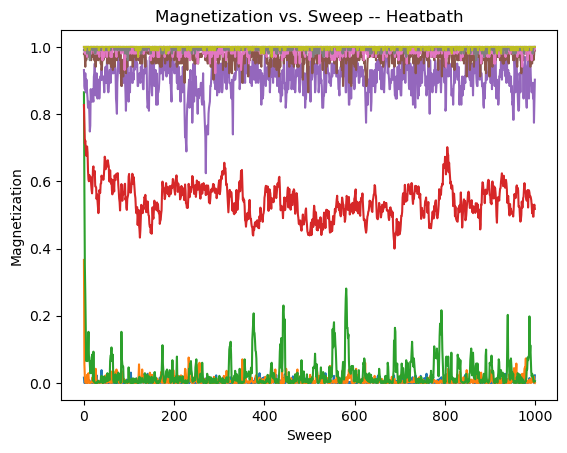

In [64]:
for M in Ms:
    plt.plot(M)

plt.xlabel("Sweep")
plt.ylabel("Magnetization")
plt.title("Magnetization vs. Sweep -- Heatbath")
plt.show()

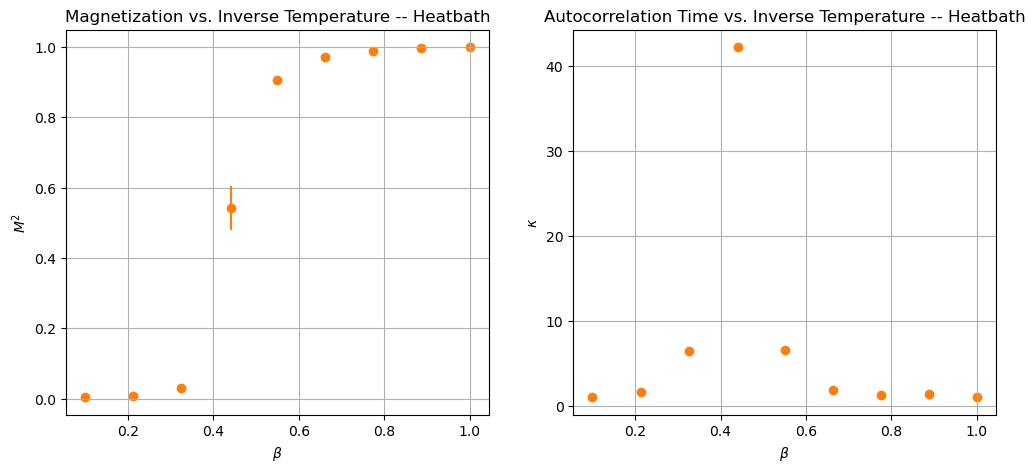

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for idx, M in enumerate(Ms):
    axs[0].scatter(betas[idx], np.mean(M), color="C1")
    axs[0].errorbar(betas[idx], np.mean(M), yerr=Merrors[idx], color="C1")
    axs[1].scatter(betas[idx], kappas[idx], color="C1")
    err = Merrors[idx]

axs[0].set_xlabel(r"$\beta$")
axs[0].set_ylabel(r"$M^{2}$")
axs[0].set_title("Magnetization vs. Inverse Temperature -- Heatbath")
axs[0].grid()

axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel(r"$\kappa$")
axs[1].set_title("Autocorrelation Time vs. Inverse Temperature -- Heatbath")
axs[1].grid()
plt.show()

The autocorrelation times are slighlty lower for the heatbath algorithm than the metropolis algorithm because the heatbath algorithm is more efficient at sampling the phase space.

### Cluster 

### 5.

$T(old \rightarrow new) = 1 - \exp{-\beta \cdot dE}$

$T(new \rightarrow old) = 1 - \exp{\beta \cdot dE}$

$dE = -2 * Eij$

$A = 1 - \exp{-2 \beta J}$

### 6.

In [66]:
betas = np.linspace(0.1, 1, 9)
betas[3] = 0.44069
nsims = betas.shape[0]
spinsPerSide = 20
nparticles = spinsPerSide**2
lattice = initLattice(spinsPerSide)
nsweeps = 1000
Ms = np.zeros((nsims, nsweeps))
autocorrelations = np.zeros((nsims, nsweeps))
kappas = np.zeros(nsims)
tcutoffs = np.zeros(nsims)
Merrors = np.zeros(nsims)

for idx, beta in enumerate(betas):
    if beta == 0.44069:
        Ms_special = np.zeros((10, nsweeps))

        for i in range(10):
            Lattices = simulateCluster(lattice, beta, nsweeps)
            M = (totalMagnetization(Lattices) / nparticles) ** 2
            Ms_special[i] = M

        M = np.mean(Ms_special, axis=0)
        autocorrelation, kappa, tcutoff = actime(M)
        Ms[idx] = M
        autocorrelations[idx] = autocorrelation
        kappas[idx] = kappa
        tcutoffs[idx] = tcutoff
        Merrors[idx] = np.std(Ms_special.flatten(), ddof=1) / np.sqrt(10)

        continue

    Lattices = simulateCluster(lattice, beta, nsweeps)
    M = (totalMagnetization(Lattices) / nparticles) ** 2
    autocorrelation, kappa, tcutoff = actime(M)
    Ms[idx] = M
    autocorrelations[idx] = autocorrelation
    kappas[idx] = kappa
    tcutoffs[idx] = tcutoff
    Merrors[idx] = np.std(M, ddof=1) / spinsPerSide

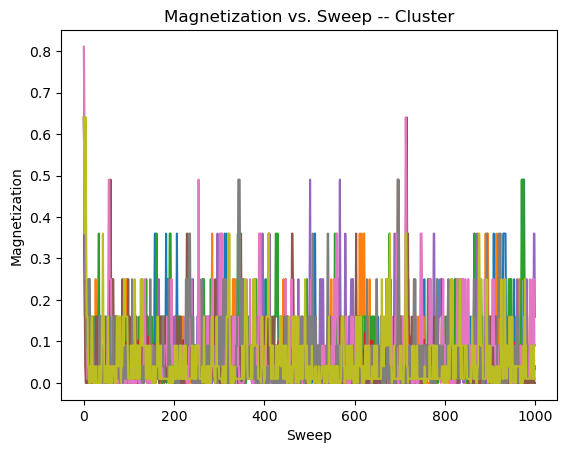

In [67]:
for M in Ms:
    plt.plot(M)

plt.xlabel("Sweep")
plt.ylabel("Magnetization")
plt.title("Magnetization vs. Sweep -- Cluster")
plt.show()

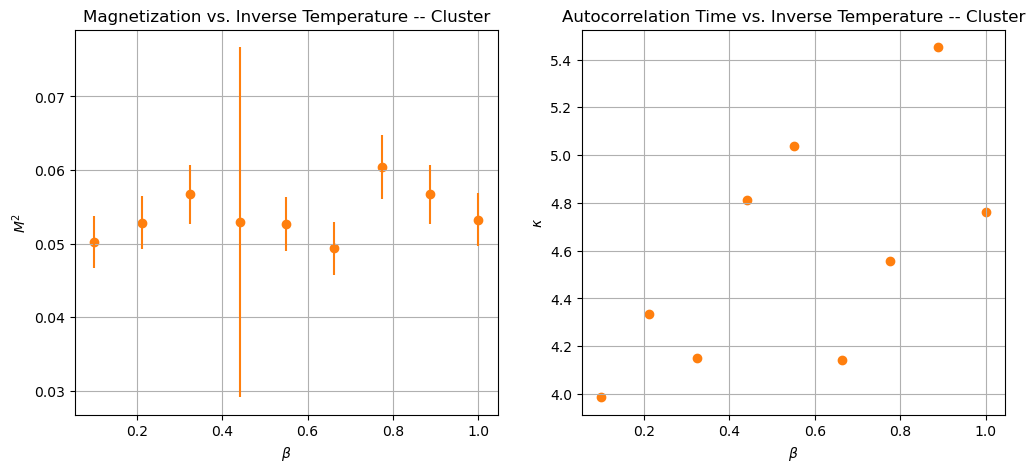

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for idx, M in enumerate(Ms):
    axs[0].scatter(betas[idx], np.mean(M), color="C1")
    axs[0].errorbar(betas[idx], np.mean(M), yerr=Merrors[idx], color="C1")
    axs[1].scatter(betas[idx], kappas[idx], color="C1")
    err = Merrors[idx]

axs[0].set_xlabel(r"$\beta$")
axs[0].set_ylabel(r"$M^{2}$")
axs[0].set_title("Magnetization vs. Inverse Temperature -- Cluster")
axs[0].grid()

axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel(r"$\kappa$")
axs[1].set_title("Autocorrelation Time vs. Inverse Temperature -- Cluster")
axs[1].grid()
plt.show()

### 7.

The metropolis and heatbath results are in good agreement, though the heatbath results have slighly lower errors and faster convergence. Pretty sure my cluster algorithm code is wrong, so I'm not sure how to interpret the results. Of the valid results, the heatbath algorithm has the lowest autocorrelation time.